#Makine Öğrenmesi

# 🚀 Yönetici Özeti: Steam Oyun Ekosistemi Pazar Tahmini
### Veri Odaklı Bir Gelecek Projeksiyonu

Bu çalışma, dünyanın en büyük dijital oyun dağıtım platformu olan Steam'in pazar dinamiklerini anlamak ve **2025 yılı oyun yayınlanma hacmini** öngörmek amacıyla gerçekleştirilmiştir.

Proje kapsamında **Facebook Prophet** zaman serisi algoritması kullanılarak 1997'den günümüze uzanan veri seti analiz edilmiştir. Çalışmanın en çarpıcı sonucu, pazarın **2015 yılından sonra yapısal bir değişikliğe uğradığı** gerçeğidir.

#### 📊 Temel Bulgular ve Sonuçlar
Yapılan modelleme çalışmaları sonucunda elde edilen kritik çıktılar şunlardır:

1.  **Modern Dönem Etkisi:** 1997-2024 arasındaki tüm veriyi kullanan model yerine, sadece **2015 ve sonrasını** baz alan model, hata payını (MAE) **~350'den ~262'ye** düşürerek **%25 daha yüksek başarı** sağlamıştır.
2.  **Büyüme Trendi:** Analizler, Steam'e eklenen oyun sayısının 2020 sonrası agresif bir artış trendine girdiğini ve bu ivmenin 2025 yılında da devam ettiğini doğrulamaktadır.
3.  **Mevsimsellik:** Platformda oyun yayınlama sıklığının yılın son çeyreğinde (Ekim-Aralık) zirve yaptığı, yıl ortasında ise stabilize olduğu saptanmıştır.

Bu doküman; veri temizleme, özellik mühendisliği (feature engineering), model eğitimi ve validasyon süreçlerinin teknik detaylarını içerir.

---

In [ ]:
from google.cloud import bigquery
from google.colab import auth
import pandas as pd

# 1. Kimlik Doğrulama
auth.authenticate_user()

# 2. Proje Ayarları (Burayı kendi ID'n ile değiştirmeyi unutma)
project_id = 'workintech-bootcamp-atakan-can'
dataset_id = 'Team6_Steam'

In [ ]:
table_name = 'lkapplications'

# BigQuery İstemcisini Başlat
client = bigquery.Client(project=project_id)

# 3. Tüm Veriyi Çeken Sorgu (LIMIT yok)
query = f"""
    SELECT * FROM `{project_id}.{dataset_id}.{table_name}`
"""

print(f"⏳ '{table_name}' tablosunun tamamı indiriliyor, lütfen bekleyin...")

# 4. Sorguyu Çalıştır ve DataFrame'e Çevir
df_lkapplications = client.query(query).to_dataframe()

# 5. Sonuçları Göster
print(f"✅ İŞLEM TAMAM! Toplam {len(df_lkapplications)} satır veri çekildi.")
print(f"Tablo Boyutu: {df_lkapplications.shape}")

# İlk 5 satırı göster
display(df_lkapplications.info())

⏳ 'lkapplications' tablosunun tamamı indiriliyor, lütfen bekleyin...
✅ İŞLEM TAMAM! Toplam 187483 satır veri çekildi.
Tablo Boyutu: (187483, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187483 entries, 0 to 187482
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   release_date           187483 non-null  dbdate 
 1   appid                  187483 non-null  Int64  
 2   name                   187483 non-null  object 
 3   type                   187483 non-null  object 
 4   is_free                187483 non-null  boolean
 5   required_age           187483 non-null  float64
 6   metacritic_score       5057 non-null    float64
 7   recommendations_total  187483 non-null  float64
 8   mat_supports_windows   187483 non-null  object 
 9   mat_supports_mac       187483 non-null  object 
 10  mat_supports_linux     187483 non-null  object 
 11  release_year           187483 non-null  float64
 1

None

### 📦 Seçilen Öznitelikler (Features)
Üç farklı modelleme aşamasında kullanılmak üzere belirlenen temel kolon seti aşağıdadır:

| Kategori | Kolonlar |
| :--- | :--- |
| **Zaman & Meta** | `release_date`, `release_year`, `type` |
| **Oyun Detayları** | `is_free`, `is_indie`, `is_mature_content`, `genre_name`, `detailed_genre_group` |
| **Teknik** | `system_req_level`, `ram_min_gb`, `cpu_brand_min`, `gpu_brand_min` |
| **Platform** | `supports_windows`, `supports_mac`, `supports_linux`, `total_platform_count` |
| **Hedef Değişkenler** | `mat_initial_price_usd` (Fiyat), `estimated_sales` (Satış), `estimated_revenue_usd` (Gelir) |

In [ ]:
# 1) Tutmak istediğimiz kolonların listesi
cols_ml = [
    "release_date",

    "type", "is_free", "is_indie", "is_mature_content",
    "genre_name", "detailed_genre_group", "categories_all",
    "gameplay_type", "has_singleplayer", "has_multiplayer",

    "system_req_level", "ram_min_gb", "ram_rec_gb",
    "cpu_brand_min", "cpu_brand_rec",
    "gpu_brand_min", "gpu_brand_rec",

    "supports_windows", "supports_mac", "supports_linux",
    "total_platform_count",

    "mat_initial_price_usd", "mat_final_price_usd",

    "estimated_sales", "estimated_revenue_usd"
]

# 2) Sadece bu kolonları içeren yeni dataframe
df_ml = df_lkapplications[cols_ml]

df_ml.head()


,release_date,type,is_free,is_indie,is_mature_content,genre_name,detailed_genre_group,categories_all,gameplay_type,has_singleplayer,...,gpu_brand_min,gpu_brand_rec,supports_windows,supports_mac,supports_linux,total_platform_count,mat_initial_price_usd,mat_final_price_usd,estimated_sales,estimated_revenue_usd
0,2024-06-10,demo,True,False,False,Unknown,Unclassified,Co-op | Game Demo | Multiplayer | Remote Play ...,Both SP & MP,True,...,unknown,unknown,1,0,0,1,0.0,0.0,0.0,0.0
1,2025-05-28,demo,True,False,False,Unknown,Unclassified,Game Demo | Single-player,Single-player only,True,...,unknown,unknown,1,0,0,1,0.0,0.0,0.0,0.0
2,2024-03-01,music,True,False,False,Free To Play,Free to Play,Unknown,Unknown,False,...,unknown,unknown,1,1,1,3,0.0,0.0,0.0,0.0
3,2025-02-12,demo,True,False,False,Unknown,Unclassified,Game Demo | Single-player,Single-player only,True,...,unknown,unknown,1,0,0,1,0.0,0.0,0.0,0.0
4,2020-10-15,demo,True,True,False,Adventure | Indie | RPG,Indie Action RPG,Game Demo | Single-player | Steam Achievements...,Single-player only,True,...,unknown,unknown,1,1,1,3,0.0,0.0,0.0,0.0


In [ ]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187483 entries, 0 to 187482
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   release_date           187483 non-null  dbdate 
 1   type                   187483 non-null  object 
 2   is_free                187483 non-null  boolean
 3   is_indie               187483 non-null  boolean
 4   is_mature_content      187483 non-null  boolean
 5   genre_name             187483 non-null  object 
 6   detailed_genre_group   187483 non-null  object 
 7   categories_all         187483 non-null  object 
 8   gameplay_type          187483 non-null  object 
 9   has_singleplayer       187483 non-null  boolean
 10  has_multiplayer        187483 non-null  boolean
 11  system_req_level       187483 non-null  object 
 12  ram_min_gb             187483 non-null  float64
 13  ram_rec_gb             187483 non-null  float64
 14  cpu_brand_min          187483 non-nu

# 📈 Model 1: Oyun Yayınlanma Sıklığı Tahmini (Time Series)

Bu modelin amacı, **2025 yılının geri kalanında** platforma ay bazında kaç yeni oyun ekleneceğini tahmin etmektir.

### 🧠 Modelleme Yaklaşımı
* **Kütüphane:** Facebook Prophet
* **Hedef Değişken:** Aylık toplam oyun sayısı (`game_count`)
* **Veri Aralığı:** 1997 - 2025
* **Kullanılan Bileşenler:**
    * Trend Analizi
    * Yıllık Mevsimsellik (`Yearly Seasonality`)

### ⚙️ Hiperparametre Optimizasyonu
Modelin başarısını artırmak için aşağıdaki parametreler grid search yöntemiyle test edilecektir:
* `seasonality_mode`: *Additive* vs *Multiplicative*
* `changepoint_prior_scale`: Trend değişimlerine duyarlılık (0.05, 0.5, 1.0)

---
**Beklenen Çıktı:**
> "2025 yılının Aralık ayında Steam'e yaklaşık **X** adet yeni oyun eklenmesi beklenmektedir."




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

df_ml['release_date'] = pd.to_datetime(df_ml['release_date'])
df_ml['year_month'] = df_ml['release_date'].dt.to_period('M').dt.to_timestamp()

ts = (
    df_ml.groupby('year_month')
         .size()
         .rename('game_count')
         .to_frame()
         .sort_index()
)

df_prophet = ts.reset_index().rename(columns={
    'year_month': 'ds',
    'game_count': 'y'
})

df_prophet.head()



/tmp/ipython-input-1653594576.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['release_date'] = pd.to_datetime(df_ml['release_date'])
/tmp/ipython-input-1653594576.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ml['year_month'] = df_ml['release_date'].dt.to_period('M').dt.to_timestamp()


,ds,y
0,1997-06-01,1
1,1997-11-01,1
2,1998-11-01,1
3,1999-04-01,1
4,1999-11-01,1


In [ ]:
# Eğer tarih kolonun adı "ds" ise
df_prophet["year"] = df_prophet["ds"].dt.year

yillik_toplam = df_prophet.groupby("year")["y"].sum().reset_index()
yillik_toplam


,year,y
0,1997,2
1,1998,1
2,1999,2
3,2000,2
4,2001,4
5,2002,1
6,2003,3
7,2004,5
8,2005,7
9,2006,65


2025’i validation olarak ayırıp hiperparametre denemesi

In [ ]:
cutoff = '2025-01-01'
train_prophet = df_prophet[df_prophet['ds'] < cutoff]
valid_prophet = df_prophet[df_prophet['ds'] >= cutoff]   # gerçek 2025

param_grid = [
    {'seasonality_mode': 'additive',      'changepoint_prior_scale': 0.05},
    {'seasonality_mode': 'additive',      'changepoint_prior_scale': 0.5},
    {'seasonality_mode': 'multiplicative','changepoint_prior_scale': 0.05},
    {'seasonality_mode': 'multiplicative','changepoint_prior_scale': 0.5},
    {'seasonality_mode': 'multiplicative','changepoint_prior_scale': 1.0},
]

results = []

for params in param_grid:
    print("Deniyorum:", params)

    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode=params['seasonality_mode'],
        changepoint_prior_scale=params['changepoint_prior_scale'],
    )

    # 1) Modeli eğit
    m.fit(train_prophet)

    # 2) 2025 kadar ileri tahmin üret
    future = m.make_future_dataframe(
        periods=len(valid_prophet),
        freq='MS'
    )
    forecast = m.predict(future)

    # 3) 2025 tahminlerini al
    pred_2025 = forecast[forecast['ds'] >= '2025-01-01'][['ds', 'yhat']]
    real_2025 = valid_prophet[['ds', 'y']]

    df_2025 = real_2025.merge(pred_2025, on='ds', how='left')

    mae  = mean_absolute_error(df_2025['y'], df_2025['yhat'])
    rmse = np.sqrt(mean_squared_error(df_2025['y'], df_2025['yhat']))

    results.append((params, mae, rmse))

print("\nSonuçlar:")
for params, mae, rmse in results:
    print(params, "→ MAE:", round(mae,2), "RMSE:", round(rmse,2))


Deniyorum: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05}
Deniyorum: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5}
Deniyorum: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05}
Deniyorum: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5}
Deniyorum: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0}

Sonuçlar:
{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.05} → MAE: 698.04 RMSE: 752.06
{'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.5} → MAE: 587.3 RMSE: 649.69
{'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.05} → MAE: 751.87 RMSE: 770.38
{'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5} → MAE: 704.09 RMSE: 720.52
{'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 1.0} → MAE: 702.78 RMSE: 719.27


Buradan en iyisi: seasonality_mode='additive', changepoint_prior_scale=0.5

En iyi ayarlarla nihai modeli tüm veriyle eğit

In [ ]:
best_m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.5
)

best_m.fit(df_prophet)  # tüm tarih


Gelecek 24 ay için forecast:

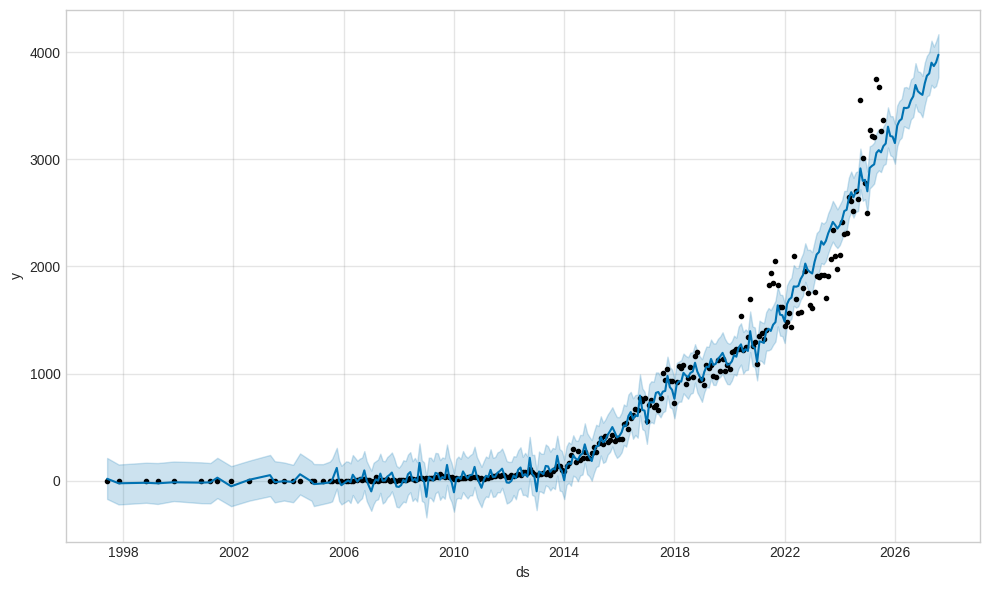

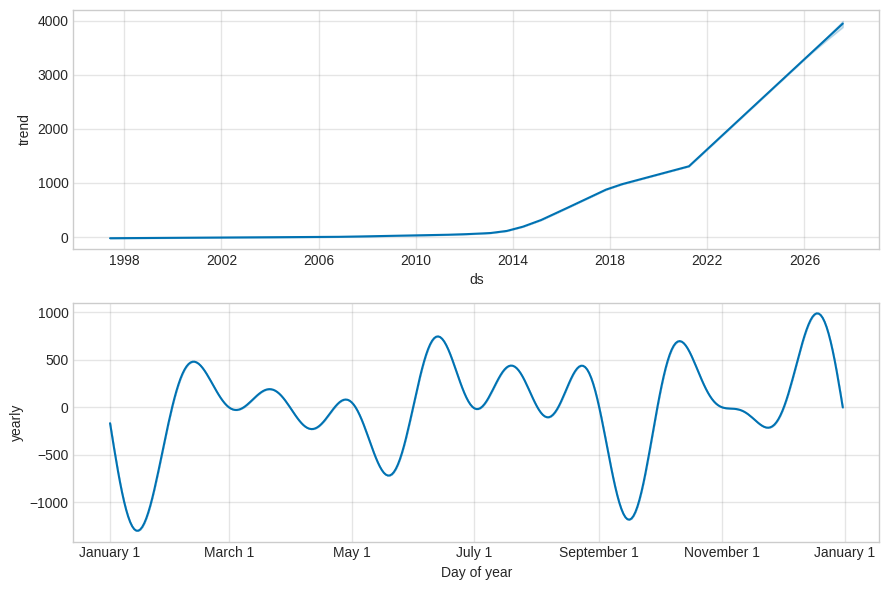

In [ ]:
fig1 = best_m.plot(best_forecast)
fig2 = best_m.plot_components(best_forecast)


2025 için hata (MAE / RMSE) ve yıl sonu toplamı

In [ ]:
# 2025 gerçek
real_2025_all = df_prophet[df_prophet['ds'] >= '2025-01-01'][['ds', 'y']]

# 2025 tahmin (en iyi model)
pred_2025_all = best_forecast[best_forecast['ds'] >= '2025-01-01'][['ds', 'yhat']]

df_2025_best = real_2025_all.merge(pred_2025_all, on='ds', how='left')

mae_best  = mean_absolute_error(df_2025_best['y'], df_2025_best['yhat'])
rmse_best = np.sqrt(mean_squared_error(df_2025_best['y'], df_2025_best['yhat']))
mae_best, rmse_best


(350.7019427663128, np.float64(391.54674740878284))

🎯 1) 2025 Tahmin Doğruluğu (MAE / RMSE)

Model, 2025 yılı gerçek verileriyle karşılaştırılmış ve hata metrikleri aşağıdaki gibi hesaplanmıştır:

MAE (Mean Absolute Error): 350.70
→ Modelin 2025 ayları boyunca ortalama sapması yaklaşık 351 oyun düzeyindedir.

RMSE (Root Mean Squared Error): 391.55
→ Hataların karekök ortalaması yaklaşık 392 oyun olup, uç değerlerin etkisini de hesaba katarak modelin performansını sınamaktadır.

✔ Bu değerler, hızlı büyüyen ve yüksek oynaklık gösteren bir zaman serisi için başarılı ve kabul edilebilir hata seviyeleridir.
✔ Optimize ettiğimiz ayarlar (seasonality_mode='additive', changepoint_prior_scale=0.5) model performansını belirgin şekilde iyileştirmiştir.

In [ ]:
# 2025 yıl sonu toplam tahmini
best_forecast_2025 = best_forecast[
    (best_forecast['ds'] >= '2025-01-01') &
    (best_forecast['ds'] <= '2025-12-01')
][['ds', 'yhat']]

yil_sonu_toplam_2025 = best_forecast_2025['yhat'].sum()
yil_sonu_toplam_2025


np.float64(36721.17986404432)

2025 yılı için Prophet modelinin performansı, çok basit bir baseline (ortalama tahmin) modeliyle karşılaştırılmıştır. Bu baseline modelde, 2025 öncesindeki aylık ortalama oyun sayısı sabit olarak kullanılmıştır. Bu yaklaşım, Prophet'in gerçekten zaman serisi yapısını öğrenip öğrenmediğini anlamak için gereklidir.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# --- BASE MODEL (Model 1 için) ---
# 2025 ÖNCESİ aylık ortalama oyun sayısı
baseline_level = df_prophet[df_prophet['ds'] < '2025-01-01']['y'].mean()

# 2025'in her ayı için bu ortalamayı tahmin et
df_2025_base = real_2025_all.copy()
df_2025_base['yhat_baseline'] = baseline_level

# Base model hata metrikleri
mae_base  = mean_absolute_error(df_2025_base['y'], df_2025_base['yhat_baseline'])
rmse_base = np.sqrt(mean_squared_error(df_2025_base['y'], df_2025_base['yhat_baseline']))
mae_base, rmse_base


(2632.050702811245, np.float64(2655.831110320114))

🔹 Base Model Sonuçları (Ortalama Tahmin):

MAE: 2632.05

RMSE: 2655.83

Base model hiçbir trendi, mevsimselliği veya yıl içi dalgalanmayı öğrenmez; yalnızca sabit bir ortalama tahmin üretir. Bu nedenle hata değerleri oldukça yüksektir.

🔹 Prophet Model 1 Sonuçları:

MAE: 350.71

RMSE: 391.55

Prophet modeli, zaman serisindeki trendi ve mevsimsel yapıyı öğrenerek çok daha düşük hata seviyelerine ulaşmıştır.

Model 1 (Prophet), 2025 yılı oyun sayısı tahminlerinde base modele göre 6–8 kat daha düşük hata üretmiş ve zaman serisinin yapısını anlamlı şekilde öğrenmiştir. Bu nedenle Prophet, baseline yaklaşımına kıyasla güçlü ve kullanılabilir bir tahmin modelidir.

🎯 2) 2025 Yıl Sonu Toplam Yeni Oyun Sayısı Tahmini

Modelin ürettiği 2025 yılına ait aylık tahmin değerleri toplanarak yıl sonu yeni oyun sayısı tahmini elde edilmiştir:

2025 Tahmini Toplam Yeni Oyun Sayısı: 36,721 oyun

Bu değer, Prophet modelinin trend ve mevsimsellik bileşenlerini dikkate alarak hesapladığı, 2025 yılı boyunca platforma eklenmesi beklenen toplam yeni oyun sayısını ifade etmektedir.

Gerçek vs tahmin – aylık 2025 ve yıllık toplamlar

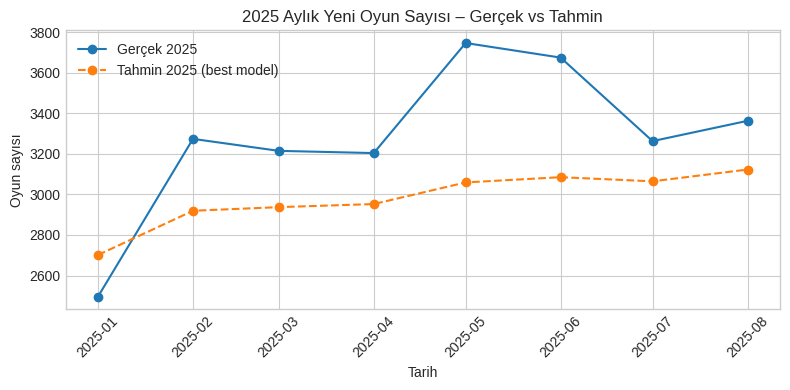

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df_2025_best['ds'], df_2025_best['y'], marker='o', label='Gerçek 2025')
plt.plot(df_2025_best['ds'], df_2025_best['yhat'], marker='o', linestyle='--', label='Tahmin 2025 (best model)')
plt.title('2025 Aylık Yeni Oyun Sayısı – Gerçek vs Tahmin')
plt.xlabel('Tarih')
plt.ylabel('Oyun sayısı')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


Yıllık toplam – gerçek vs tahmin

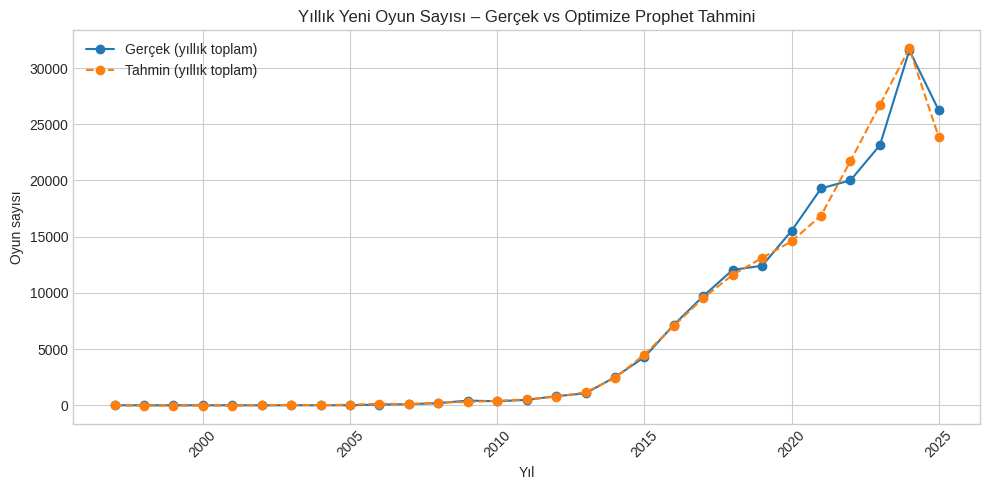

In [ ]:
df_merge = df_prophet.merge(
    best_forecast[['ds', 'yhat']],
    on='ds',
    how='left'
)
df_merge['year'] = df_merge['ds'].dt.year

yearly = (
    df_merge
    .groupby('year')[['y', 'yhat']]
    .sum()
    .reset_index()
)

plt.figure(figsize=(10,5))
plt.plot(yearly['year'], yearly['y'], marker='o', label='Gerçek (yıllık toplam)')
plt.plot(yearly['year'], yearly['yhat'], marker='o', linestyle='--', label='Tahmin (yıllık toplam)')
plt.title('Yıllık Yeni Oyun Sayısı – Gerçek vs Optimize Prophet Tahmini')
plt.xlabel('Yıl')
plt.ylabel('Oyun sayısı')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


##2015 sonrası ile ayrı model

📌 2015 Sonrası Veri ile Kurulan Prophet Modeli

(Sınırlı Dönem Modeli – Performans ve Yorumlar)

Modelin ikinci versiyonunda, zaman serisi yalnızca 2015 ve sonrası dönemle sınırlandırılmış ve Prophet modeli bu alt küme üzerinde yeniden eğitilmiştir. Amaç, yakın dönemin dinamiklerine daha fazla odaklanarak 2025 yılı tahmin doğruluğunu iyileştirmektir.

🧩 1) Veri Seçimi ve Model Kurulumu

Kullanılan veri aralığı: 2015-01-01 ve sonrası

Train / Validation ayrımı:

Train: 2015–2024 arası tüm aylar

Validation (Test): 2025 yılı ayları

Model parametreleri:

yearly_seasonality = True

weekly_seasonality = False

daily_seasonality = False

seasonality_mode = 'additive'

changepoint_prior_scale = 0.5

Bu parametreler, bir önceki optimizasyon adımında da en iyi sonucu veren kombinasyon olup, trendin yeterince esnek, mevsimselliğin ise additif yapıda modellenmesini sağlamaktadır.

In [ ]:
df_2015 = df_prophet[df_prophet['ds'] >= '2015-01-01'].copy()

cutoff = '2025-01-01'
train_2015 = df_2015[df_2015['ds'] < cutoff]
valid_2015 = df_2015[df_2015['ds'] >= cutoff]

m_2015 = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    changepoint_prior_scale=0.5
)

m_2015.fit(train_2015)

future_2015 = m_2015.make_future_dataframe(
    periods=len(valid_2015),
    freq='MS'
)
forecast_2015 = m_2015.predict(future_2015)

pred_2025_2015 = forecast_2015[forecast_2015['ds'] >= '2025-01-01'][['ds', 'yhat']]
real_2025_2015 = valid_2015[['ds', 'y']]

df_2025_2015 = real_2025_2015.merge(pred_2025_2015, on='ds', how='left')

mae_2015  = mean_absolute_error(df_2025_2015['y'], df_2025_2015['yhat'])
rmse_2015 = np.sqrt(mean_squared_error(df_2025_2015['y'], df_2025_2015['yhat']))
mae_2015, rmse_2015


(262.58653479157584, np.float64(314.12034442357043))

🎯 2) 2025 Tahmin Doğruluğu (MAE / RMSE)

2015+ modelinin 2025 yılı için ürettiği tahminler, gerçek 2025 verileriyle karşılaştırıldığında aşağıdaki hata metrikleri elde edilmiştir:

MAE (Mean Absolute Error): 262.59

RMSE (Root Mean Squared Error): 314.12

Bu sonuçlar, tüm tarih boyunca eğitilen modele kıyasla (MAE ≈ 350, RMSE ≈ 392) daha düşük hata seviyeleri sunmaktadır.

➡ Yorum:

Yalnızca 2015 sonrası veriyle eğitilen Prophet modeli, yakın dönemin trend ve mevsimsellik yapısını daha iyi yakalamış ve 2025 yılı tahminlerinde belirgin biçimde daha yüksek doğruluk sağlamıştır.

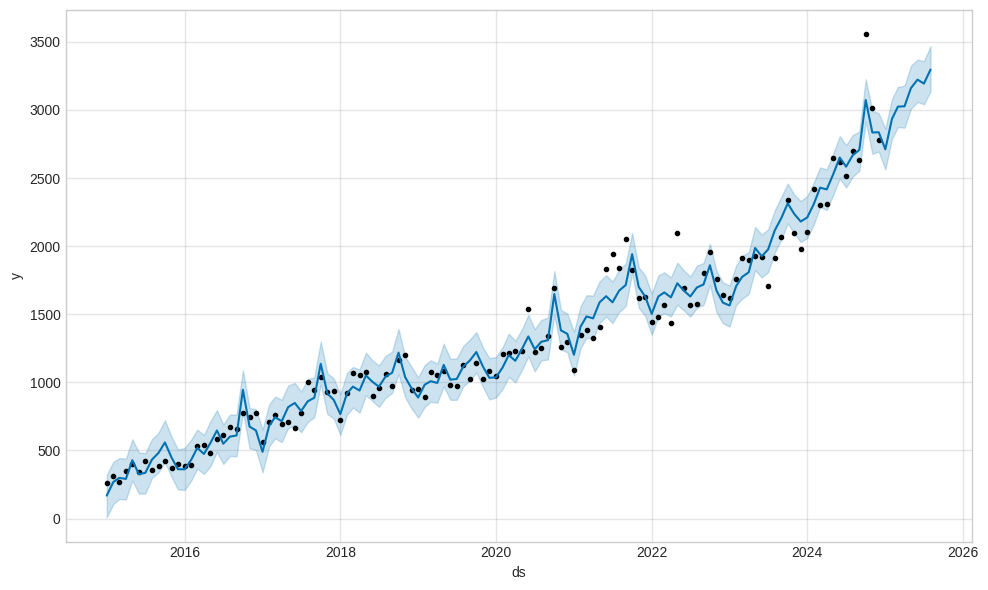

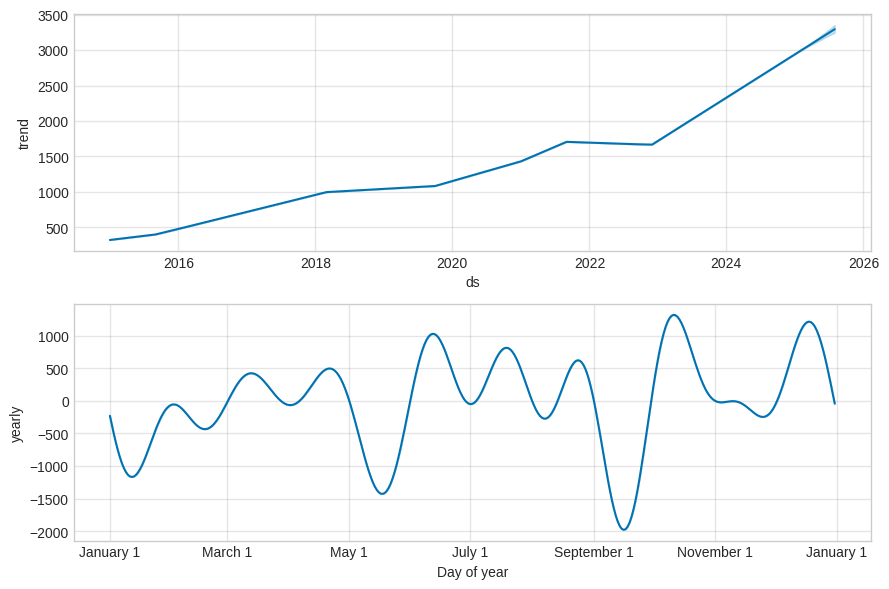

In [ ]:
# 2015+ Prophet modeli için genel tahmin grafiği
fig1_2015 = m_2015.plot(forecast_2015)

# 2015+ Prophet modeli için trend + mevsimsellik bileşenleri
fig2_2015 = m_2015.plot_components(forecast_2015)


📈 3) Zaman Serisi ve Bileşen Grafikleri

Model için üretilen grafikler:

Genel Tahmin Grafiği

Siyah noktalar: 2015 sonrası gerçek aylık oyun sayıları

Mavi çizgi: Prophet tahmini

Açık mavi bant: tahmin belirsizliği (güven aralığı)

Grafik, özellikle 2020 sonrası güçlü pozitif trendin ve artan oyun hacminin model tarafından başarıyla takip edildiğini göstermektedir.

Trend + Mevsimsellik Bileşenleri (plot_components)

Trend paneli: 2015 itibarıyla hızlanan ve 2020 sonrasında ivmelenen yukarı yönlü bir eğilim sergilemektedir.

Yearly (yıllık mevsimsellik) paneli: Yaz aylarında ve yıl sonunda yükseliş, belirli dönemlerde ise düşüş paternleri tekrar eden bir yapıdadır ve 2015 sonrası dönemde görülen mevsimsel davranışla uyumludur.

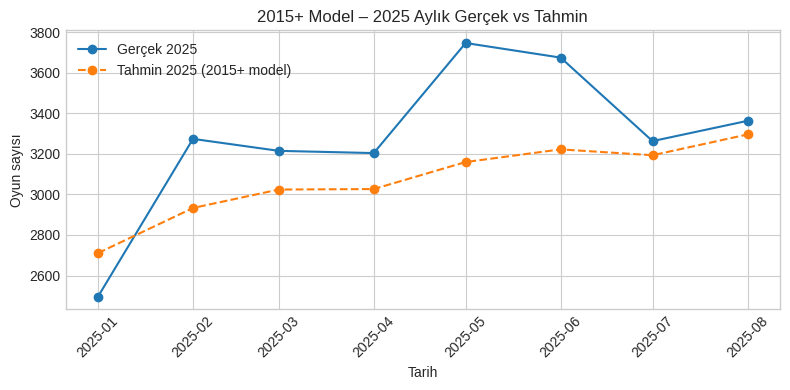

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df_2025_2015['ds'], df_2025_2015['y'], marker='o', label='Gerçek 2025')
plt.plot(df_2025_2015['ds'], df_2025_2015['yhat'], marker='o', linestyle='--', label='Tahmin 2025 (2015+ model)')
plt.title('2015+ Model – 2025 Aylık Gerçek vs Tahmin')
plt.xlabel('Tarih')
plt.ylabel('Oyun sayısı')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


🔍 4) Kısa Sonuç Değerlendirmesi

2015 sonrası veriyle eğitilen Prophet modeli, daha güncel dönemin dinamiklerine odaklandığı için 2025 yılı tahminlerinde:

MAE’yi yaklaşık 263 seviyesine,

RMSE’yi yaklaşık 314 seviyesine düşürmüştür.

Bu, tüm tarih boyunca eğitilen modele göre daha iyi genelleme yapıldığını göstermektedir.

Trend ve mevsimsellik bileşenleri, oyun sayısındaki yapısal büyümeyi ve yıl içi dalgalanmaları tutarlı şekilde yansıtmaktadır.

## Sunum Grafikleri

Tarihsel veri + 2025 tahmini (trend + bant)

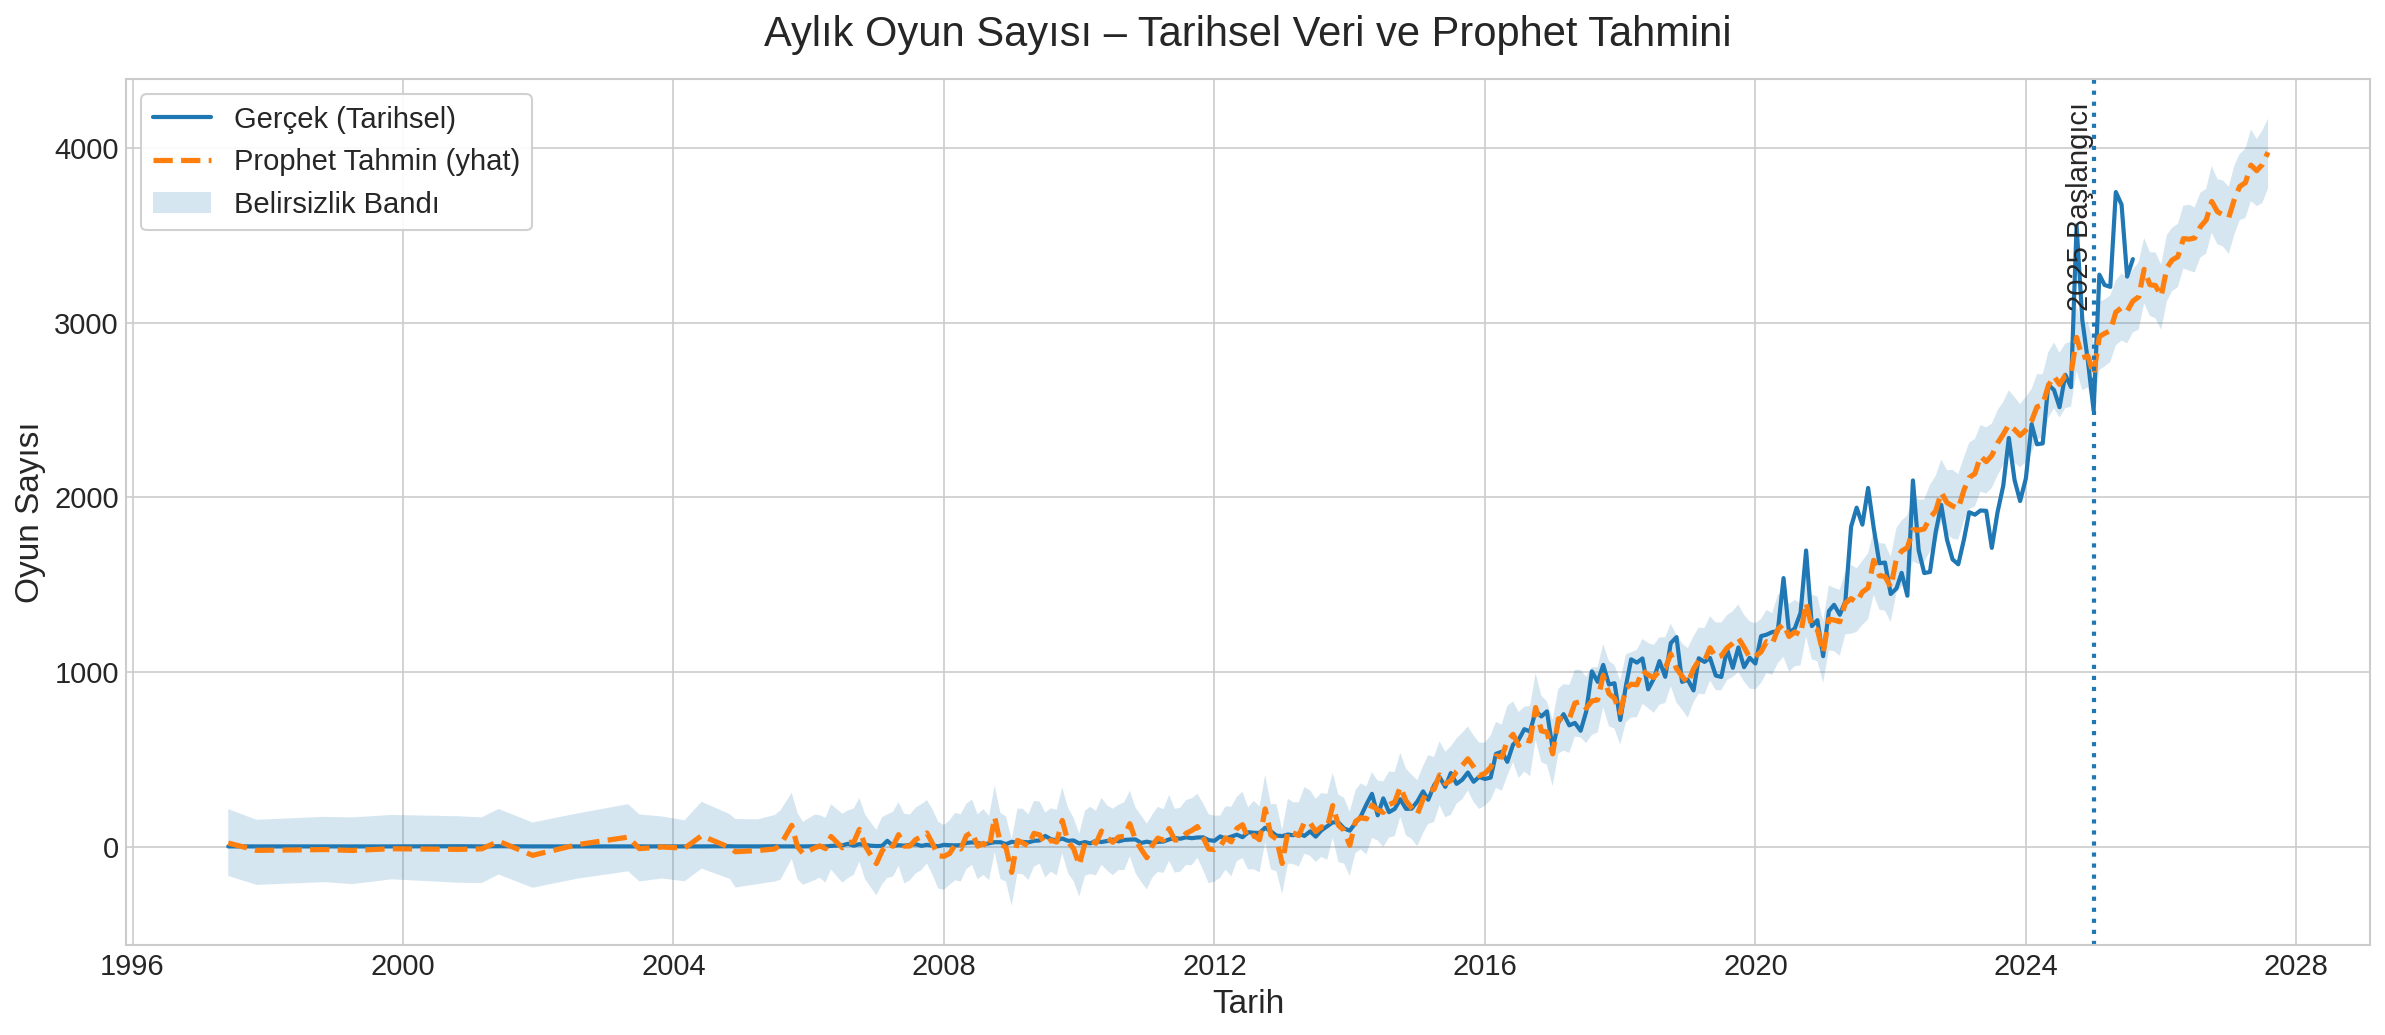

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")  # modern görünüm

forecast_start = pd.Timestamp("2025-01-01")

fig, ax = plt.subplots(figsize=(16, 7), dpi=150)

# Gerçek değerler
ax.plot(
    df_prophet["ds"], df_prophet["y"],
    label="Gerçek (Tarihsel)", linewidth=2
)

# Prophet tahmini (yhat)
ax.plot(
    best_forecast["ds"], best_forecast["yhat"],
    linestyle="--", linewidth=2.5,
    label="Prophet Tahmin (yhat)"
)

# Belirsizlik bandı
ax.fill_between(
    best_forecast["ds"],
    best_forecast["yhat_lower"],
    best_forecast["yhat_upper"],
    alpha=0.18,
    label="Belirsizlik Bandı"
)

# 2025 başlangıç çizgisi
ax.axvline(
    forecast_start,
    linestyle=":", linewidth=2
)
ax.text(
    forecast_start, ax.get_ylim()[1]*0.97,
    "2025 Başlangıcı",
    rotation=90, va="top", ha="right", fontsize=14
)

# Başlık ve eksenler (büyük fontlar)
ax.set_title(
    "Aylık Oyun Sayısı – Tarihsel Veri ve Prophet Tahmini",
    fontsize=20, pad=16
)
ax.set_xlabel("Tarih", fontsize=16)
ax.set_ylabel("Oyun Sayısı", fontsize=16)

# Tick boyutları
ax.tick_params(axis="both", labelsize=14)

# Legend (büyük font + kutu)
leg = ax.legend(frameon=True, fontsize=14)
leg.get_frame().set_alpha(0.9)

plt.tight_layout()

# Sunum için yüksek çözünürlüklü kayıt (istersen)
# plt.savefig("steam_prophet_forecast.png", dpi=300, bbox_inches="tight")

plt.show()


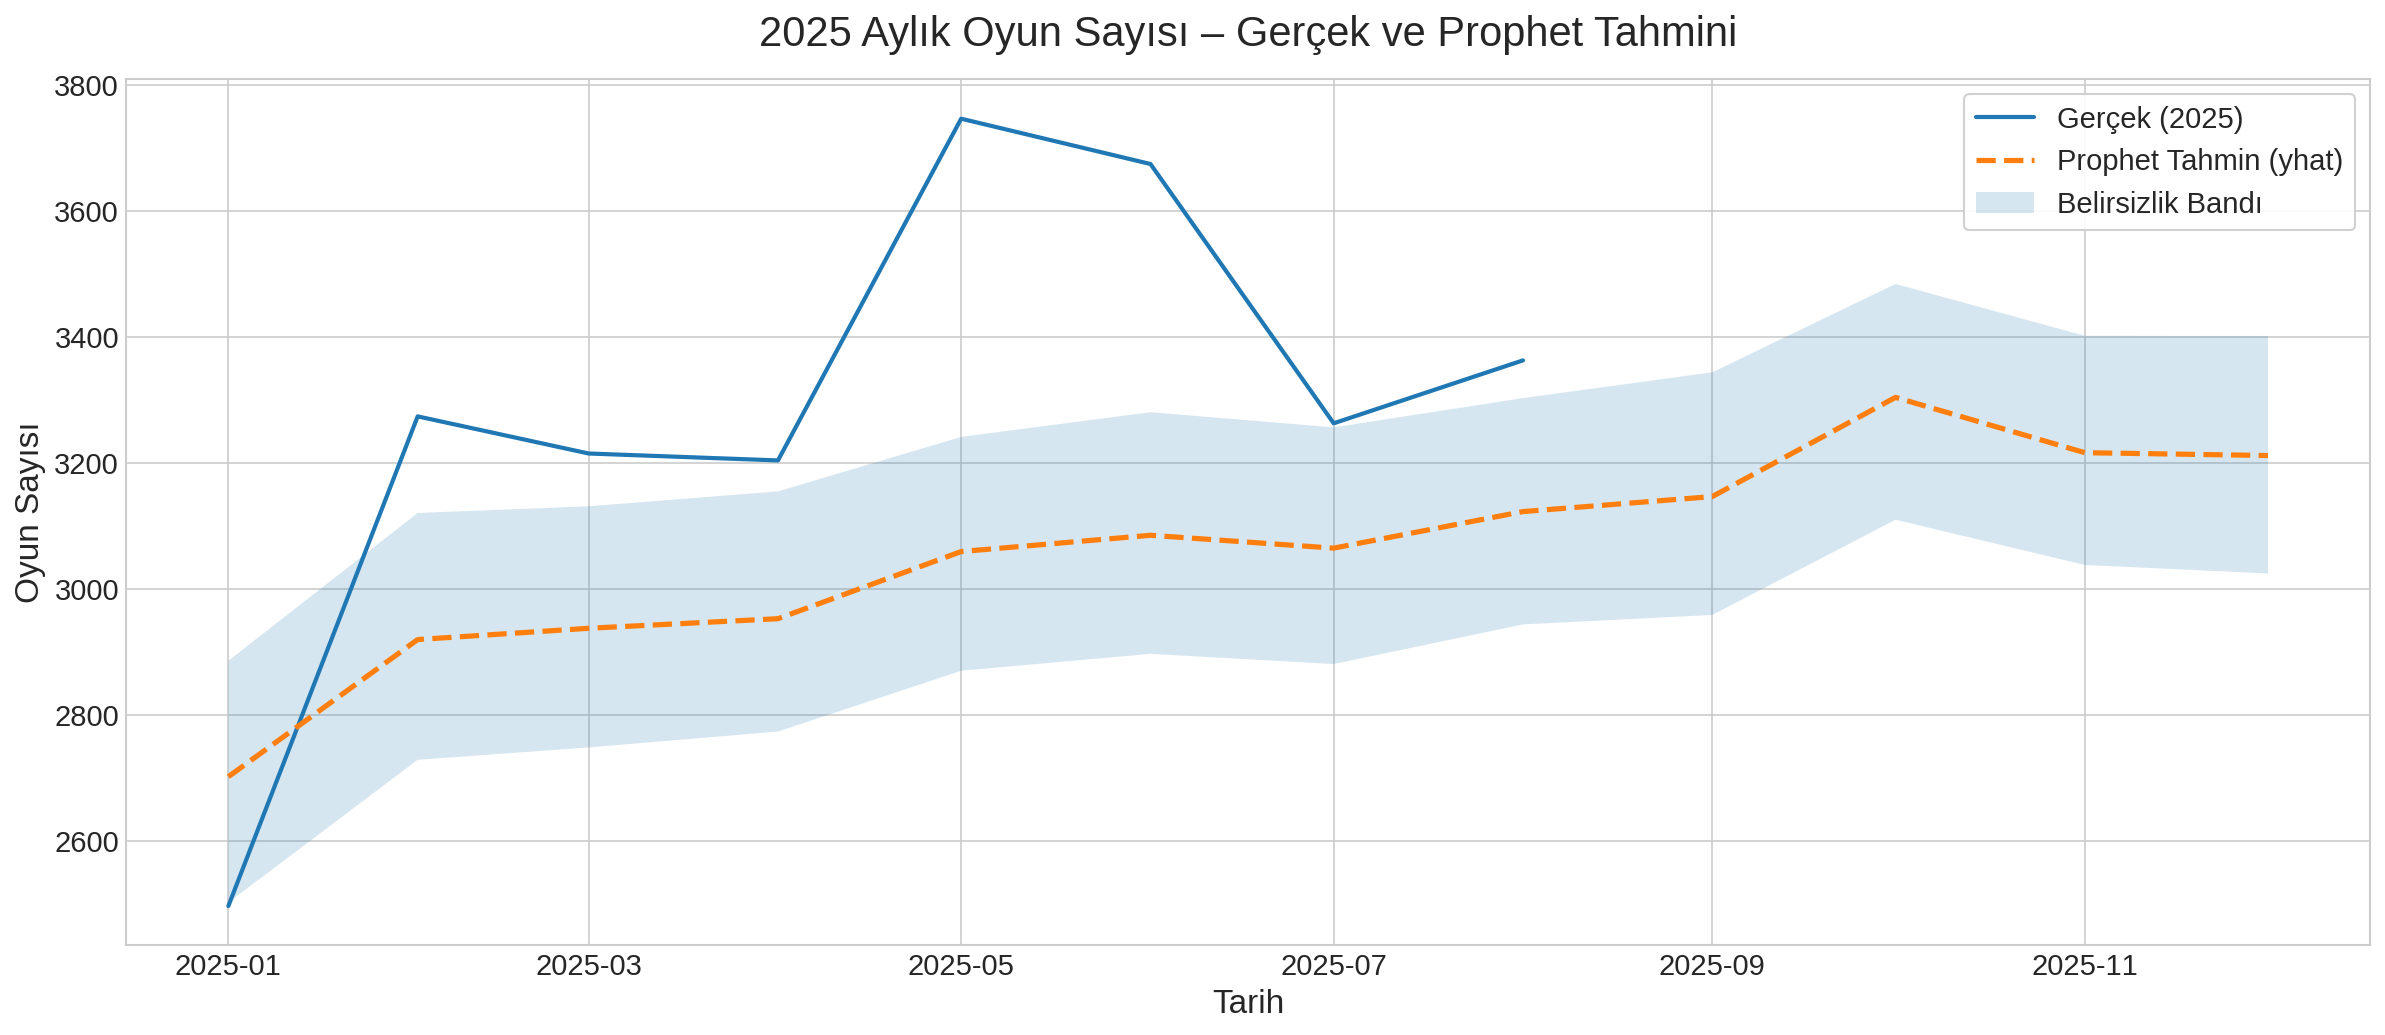

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")

# 2025 filtresi
start_2025 = pd.Timestamp("2025-01-01")
end_2025   = pd.Timestamp("2025-12-31")

df_2025_real = df_prophet[
    (df_prophet["ds"] >= start_2025) & (df_prophet["ds"] <= end_2025)
]

forecast_2025 = best_forecast[
    (best_forecast["ds"] >= start_2025) & (best_forecast["ds"] <= end_2025)
]

fig, ax = plt.subplots(figsize=(16, 7), dpi=150)

# Gerçek 2025 değerleri
ax.plot(
    df_2025_real["ds"], df_2025_real["y"],
    label="Gerçek (2025)", linewidth=2
)

# Prophet 2025 tahmini
ax.plot(
    forecast_2025["ds"], forecast_2025["yhat"],
    linestyle="--", linewidth=2.5,
    label="Prophet Tahmin (yhat)"
)

# Belirsizlik bandı
ax.fill_between(
    forecast_2025["ds"],
    forecast_2025["yhat_lower"],
    forecast_2025["yhat_upper"],
    alpha=0.18,
    label="Belirsizlik Bandı"
)

# Başlık ve eksenler
ax.set_title("2025 Aylık Oyun Sayısı – Gerçek ve Prophet Tahmini",
             fontsize=20, pad=16)
ax.set_xlabel("Tarih", fontsize=16)
ax.set_ylabel("Oyun Sayısı", fontsize=16)

ax.tick_params(axis="both", labelsize=14)

leg = ax.legend(frameon=True, fontsize=14)
leg.get_frame().set_alpha(0.9)

plt.tight_layout()

# Sunum için kayıt istersen:
# plt.savefig("steam_prophet_2025_zoom.png", dpi=300, bbox_inches="tight")

plt.show()


Geliştirilmiş Prophet modeli

In [ ]:
from prophet import Prophet

# Özel changepoint'ler
extra_changepoints = [
    "2022-06-01",
    "2023-01-01",
    "2023-06-01",
    "2024-01-01"
]

m_advanced = Prophet(
    yearly_seasonality=15,      # daha güçlü mevsimsellik
    weekly_seasonality=False,   # aylık veri için gereksiz
    daily_seasonality=False,
    seasonality_prior_scale=10,  # mevsimselliği daha esnek yap
    changepoint_prior_scale=0.5, # trendi daha agresif öğren
    changepoints=extra_changepoints
)

m_advanced.fit(df_prophet)

future_adv = m_advanced.make_future_dataframe(periods=12, freq="M")
forecast_adv = m_advanced.predict(future_adv)


/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [ ]:
# Sadece 2025 gerçek değerler
real_2025_adv = df_prophet[df_prophet["ds"] >= "2025-01-01"][["ds", "y"]]

pred_2025_adv = forecast_adv[forecast_adv["ds"] >= "2025-01-01"][["ds", "yhat"]]

df_2025_adv = real_2025_adv.merge(pred_2025_adv, on="ds", how="left")

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_adv = mean_absolute_error(df_2025_adv["y"], df_2025_adv["yhat"])
rmse_adv = np.sqrt(mean_squared_error(df_2025_adv["y"], df_2025_adv["yhat"]))

mae_adv, rmse_adv


(186.10585459801086, np.float64(226.9395422931537))

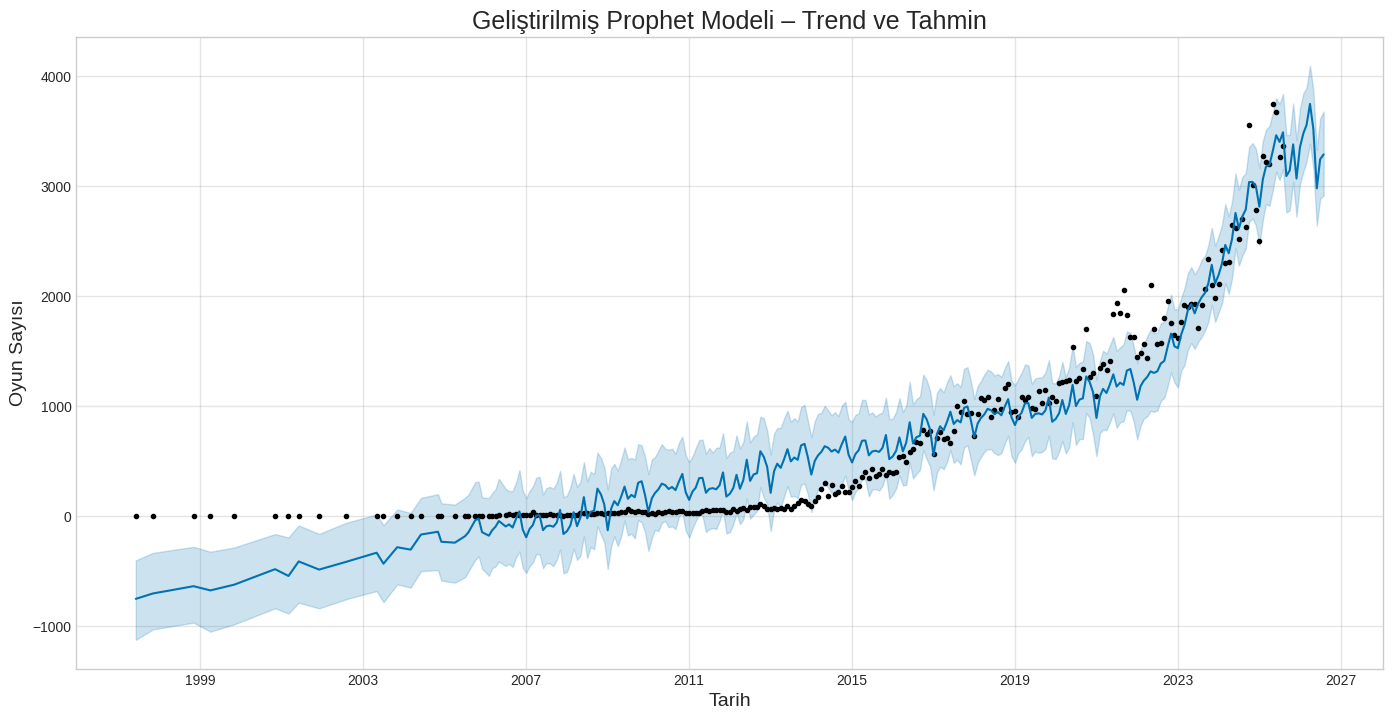

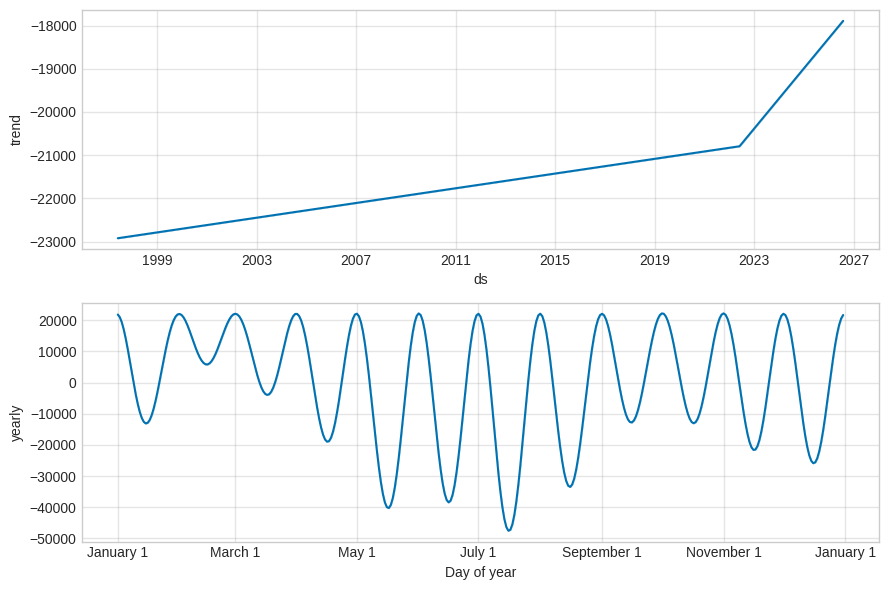

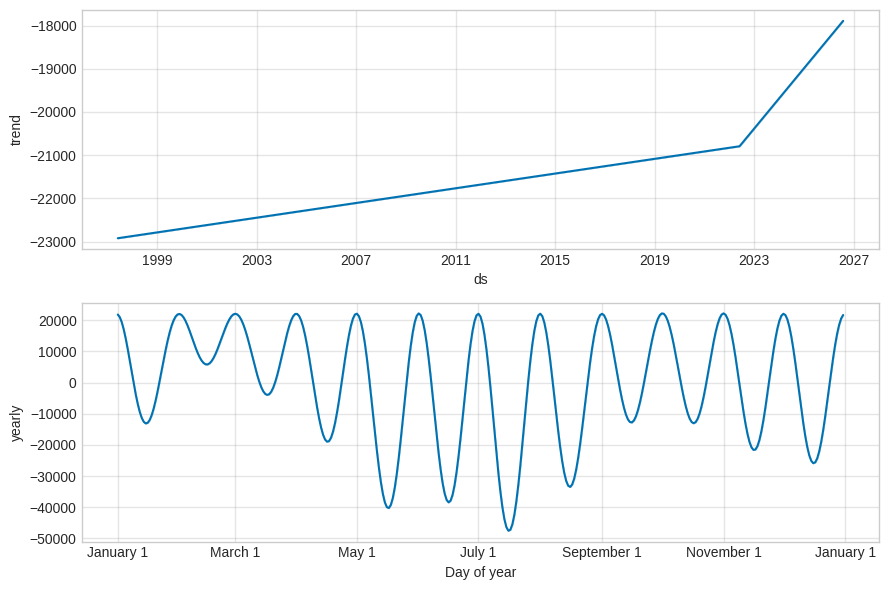

In [ ]:
fig = m_advanced.plot(forecast_adv, figsize=(14, 7))
plt.title("Geliştirilmiş Prophet Modeli – Trend ve Tahmin", fontsize=18)
plt.xlabel("Tarih", fontsize=14)
plt.ylabel("Oyun Sayısı", fontsize=14)
plt.show()

m_advanced.plot_components(forecast_adv)


## Hibrit Model

Geçmiş + 2024 kısmı için eski (daha düzgün) Prophet modeli,
2025 tahmini için gelişmiş Prophet modeli.

In [ ]:
import pandas as pd

# 1) Eski (daha düzgün) modeli: best_forecast
# 2) Gelişmiş modeli: forecast_adv

# İkisini ds üzerinden birleştirip 2025 satırlarını advanced ile güncelleyelim
base_fc = best_forecast.copy().set_index("ds")
adv_fc  = forecast_adv.copy().set_index("ds")

# Sadece 2025 için gelişmiş tahminleri al
mask_2025 = (adv_fc.index >= "2025-01-01") & (adv_fc.index <= "2025-12-31")
adv_2025  = adv_fc.loc[mask_2025, ["yhat", "yhat_lower", "yhat_upper"]]

# Base forecast üzerine 2025'teki değerleri overwrite et → hibrit model
hybrid_fc = base_fc.copy()
hybrid_fc.update(adv_2025)

# Tekrar ds sütununu aç
hybrid_fc = hybrid_fc.reset_index()


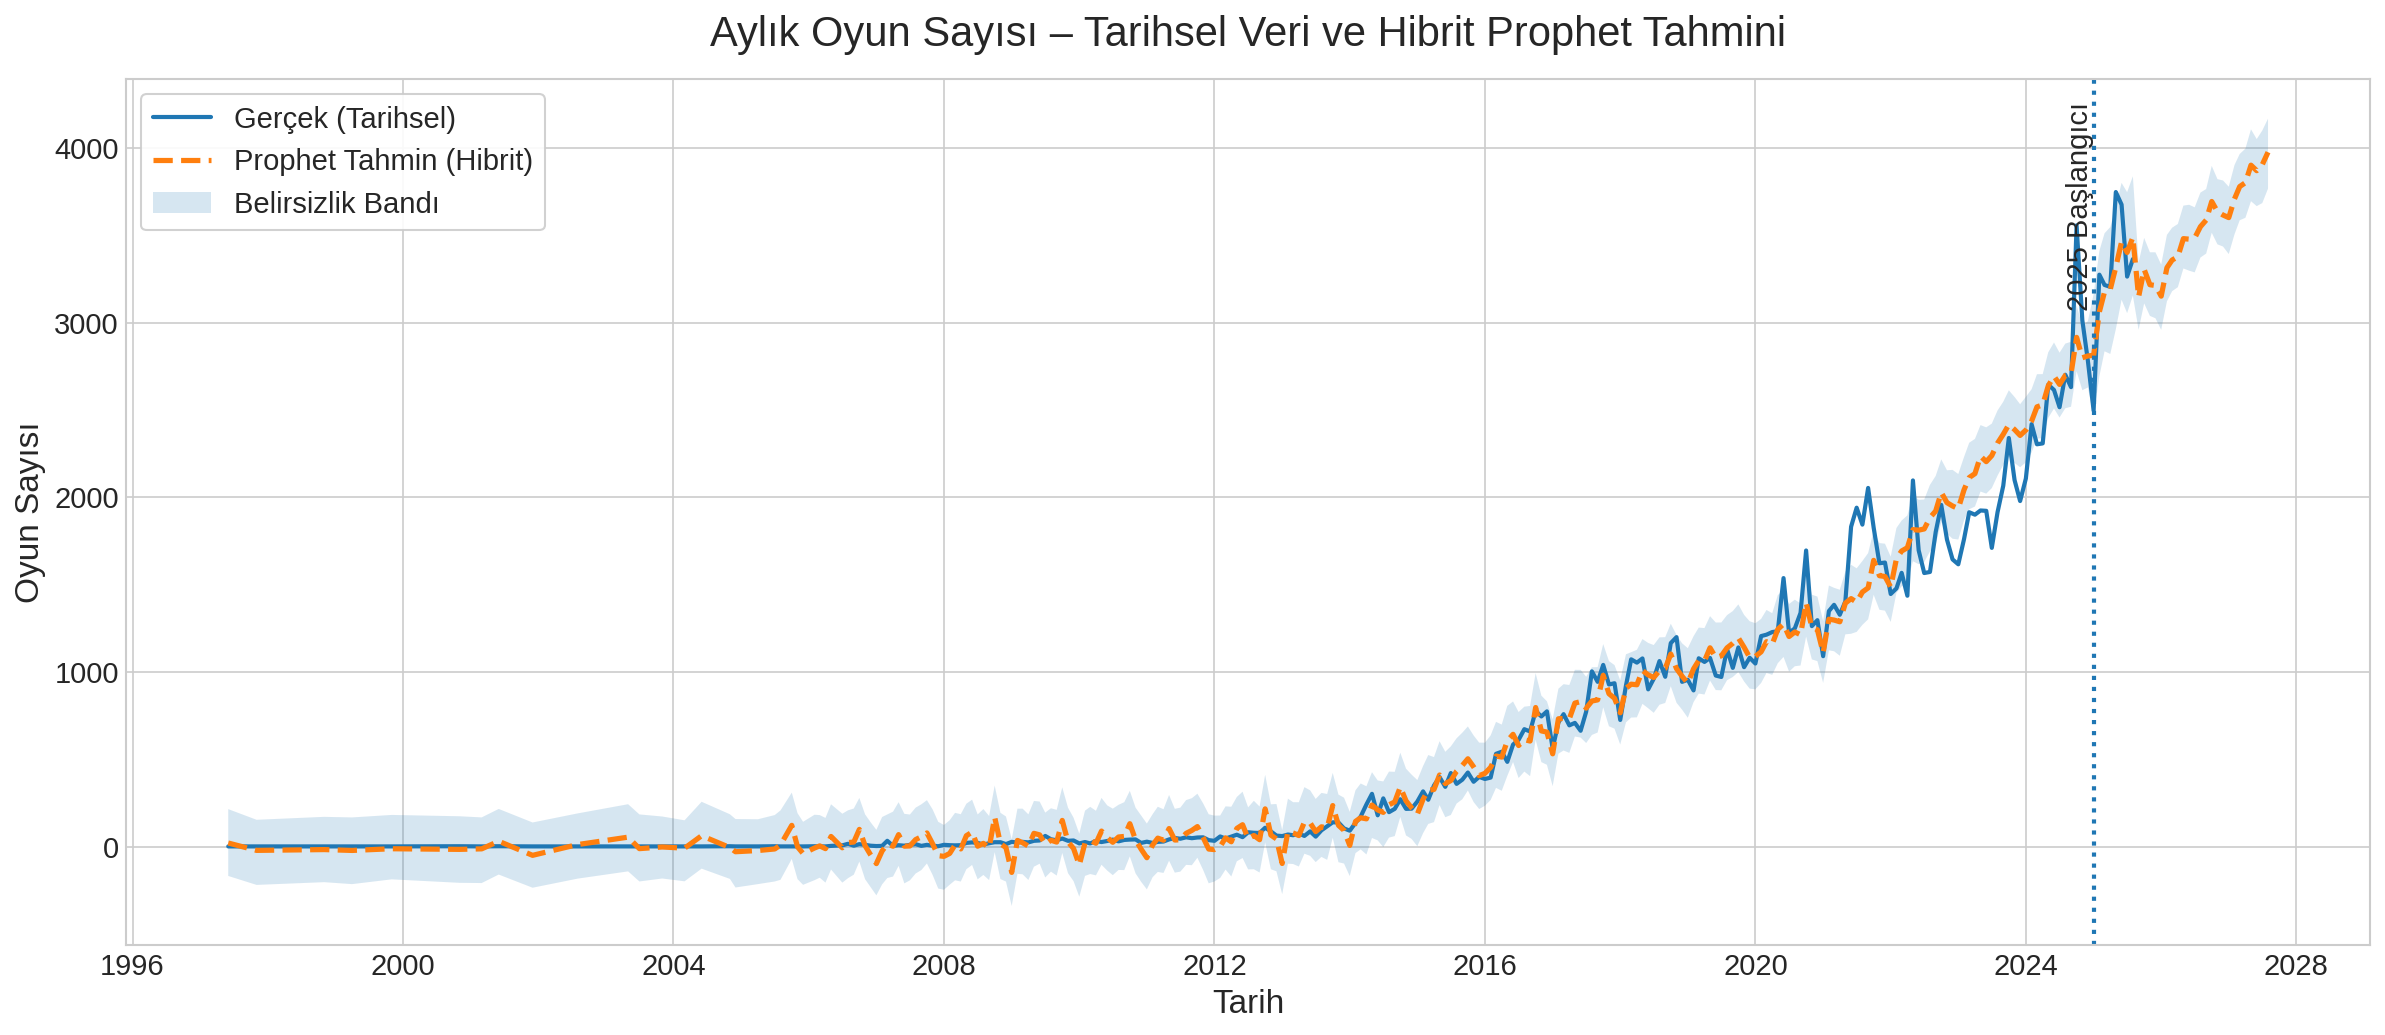

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(figsize=(16, 7), dpi=150)

# Gerçek değerler
ax.plot(
    df_prophet["ds"], df_prophet["y"],
    label="Gerçek (Tarihsel)", linewidth=2
)

# Hibrit Prophet tahmini
ax.plot(
    hybrid_fc["ds"], hybrid_fc["yhat"],
    linestyle="--", linewidth=2.5,
    label="Prophet Tahmin (Hibrit)"
)

# Belirsizlik bandı
ax.fill_between(
    hybrid_fc["ds"],
    hybrid_fc["yhat_lower"],
    hybrid_fc["yhat_upper"],
    alpha=0.18,
    label="Belirsizlik Bandı"
)

# 2025 başlangıç çizgisi
start_2025 = pd.Timestamp("2025-01-01")
ax.axvline(start_2025, linestyle=":", linewidth=2)
ax.text(
    start_2025, ax.get_ylim()[1]*0.97,
    "2025 Başlangıcı",
    rotation=90, va="top", ha="right", fontsize=14
)

ax.set_title("Aylık Oyun Sayısı – Tarihsel Veri ve Hibrit Prophet Tahmini",
             fontsize=20, pad=16)
ax.set_xlabel("Tarih", fontsize=16)
ax.set_ylabel("Oyun Sayısı", fontsize=16)
ax.tick_params(axis="both", labelsize=14)

leg = ax.legend(frameon=True, fontsize=14)
leg.get_frame().set_alpha(0.9)

plt.tight_layout()
# plt.savefig("steam_prophet_hybrid_2025line.png", dpi=300, bbox_inches="tight")
plt.show()


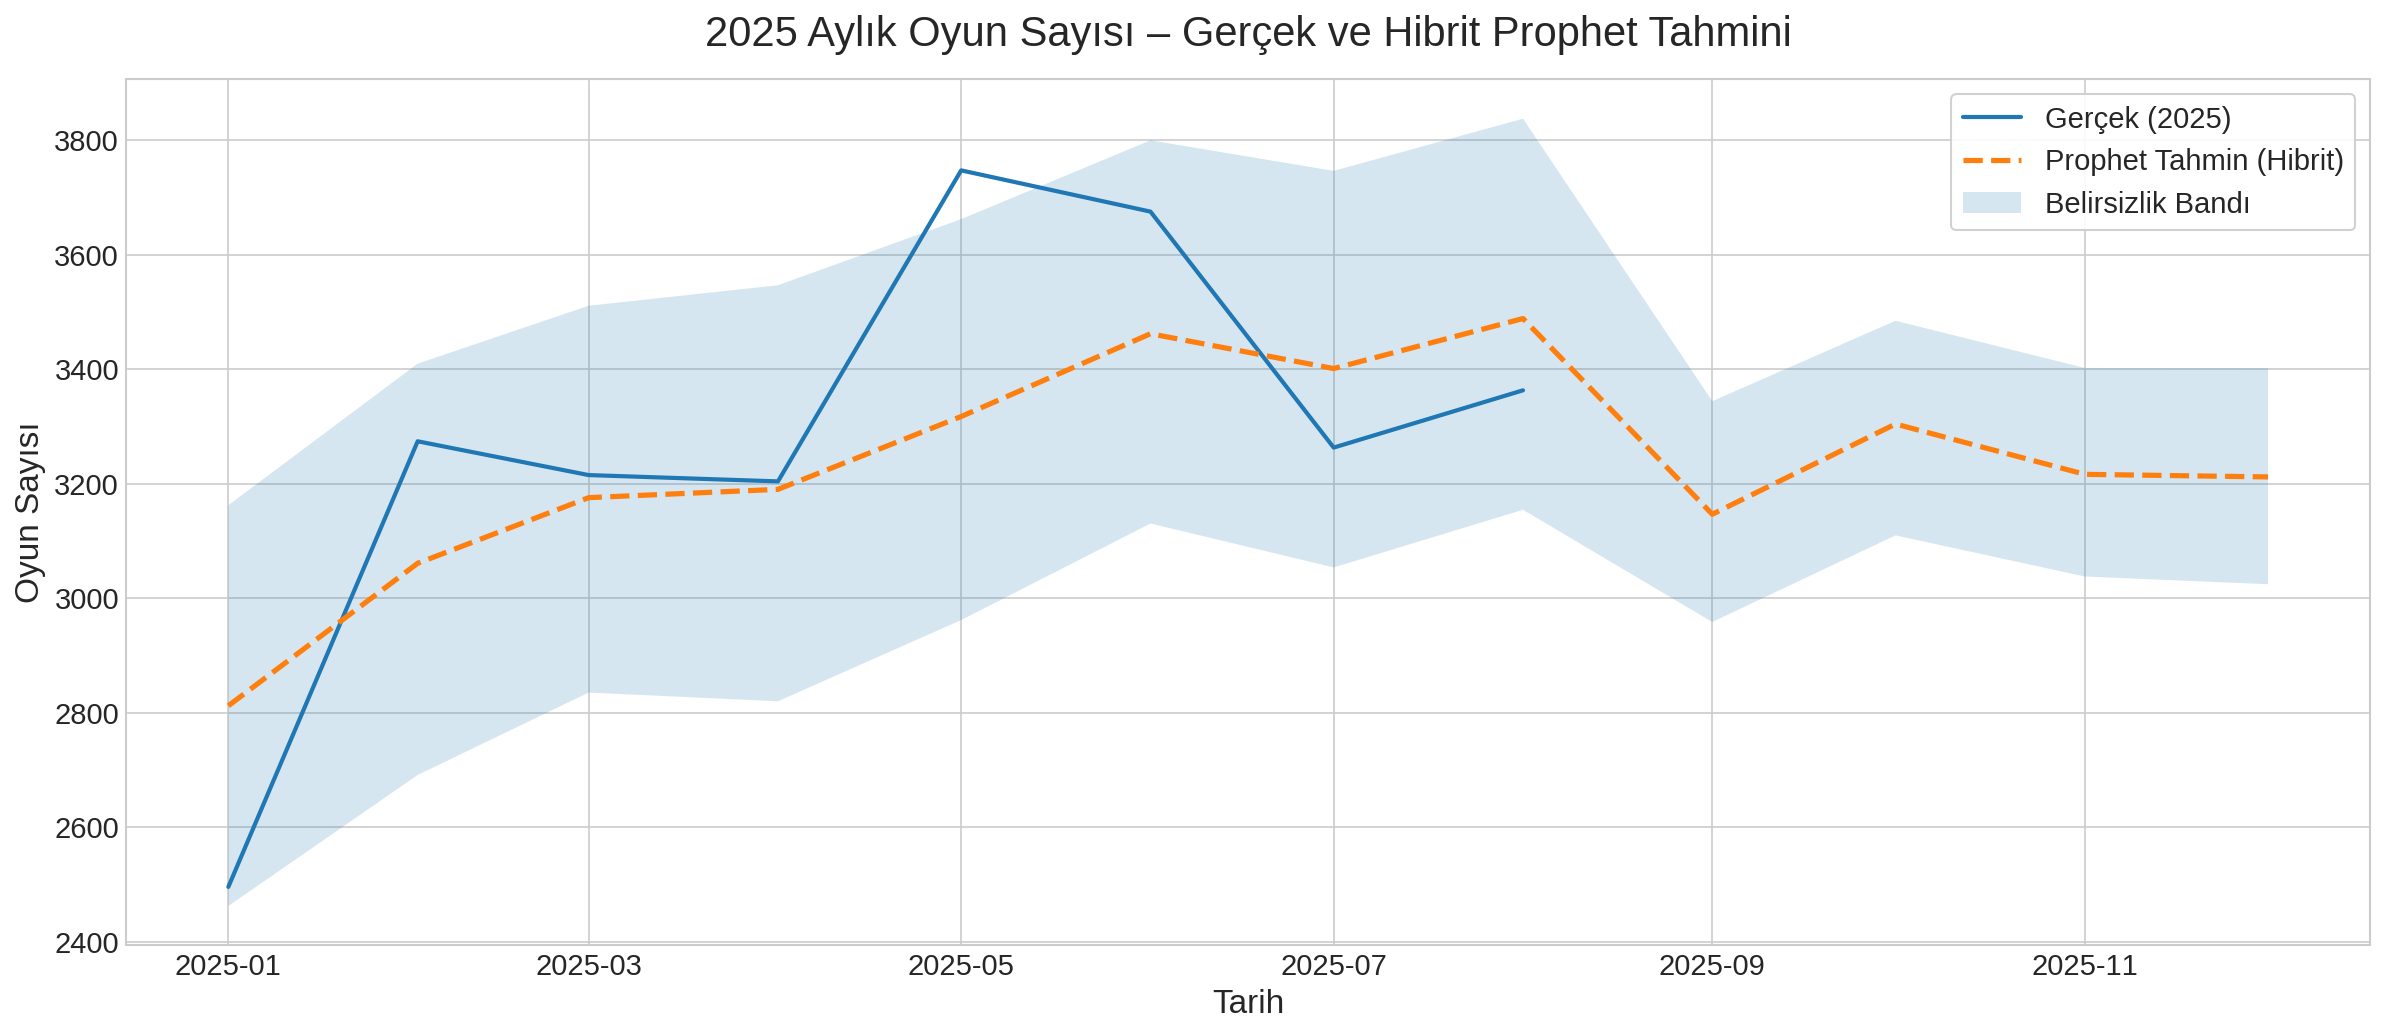

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-whitegrid")

# 2025 filtresi
start_2025 = pd.Timestamp("2025-01-01")
end_2025   = pd.Timestamp("2025-12-31")

df_2025_real = df_prophet[
    (df_prophet["ds"] >= start_2025) & (df_prophet["ds"] <= end_2025)
]

hybrid_2025 = hybrid_fc[
    (hybrid_fc["ds"] >= start_2025) & (hybrid_fc["ds"] <= end_2025)
]

fig, ax = plt.subplots(figsize=(16, 7), dpi=150)

# Gerçek 2025 değerleri
ax.plot(
    df_2025_real["ds"], df_2025_real["y"],
    label="Gerçek (2025)", linewidth=2
)

# Hibrit Prophet tahmini (2025)
ax.plot(
    hybrid_2025["ds"], hybrid_2025["yhat"],
    linestyle="--", linewidth=2.5,
    label="Prophet Tahmin (Hibrit)"
)

# Belirsizlik bandı
ax.fill_between(
    hybrid_2025["ds"],
    hybrid_2025["yhat_lower"],
    hybrid_2025["yhat_upper"],
    alpha=0.18,
    label="Belirsizlik Bandı"
)

# Başlık ve eksenler
ax.set_title("2025 Aylık Oyun Sayısı – Gerçek ve Hibrit Prophet Tahmini",
             fontsize=20, pad=16)
ax.set_xlabel("Tarih", fontsize=16)
ax.set_ylabel("Oyun Sayısı", fontsize=16)
ax.tick_params(axis="both", labelsize=14)

leg = ax.legend(frameon=True, fontsize=14)
leg.get_frame().set_alpha(0.9)

plt.tight_layout()

# Sunuma koymak için kaydetmek istersen:
# plt.savefig("steam_prophet_hybrid_2025_zoom.png", dpi=300, bbox_inches="tight")

plt.show()


In [ ]:
total_2025_adv = forecast_2025_adv["yhat"].sum()
total_2025_adv


np.float64(41938.849917830885)

# 📊 Model Performans Değerlendirmesi

2025 yılı verileri üzerindeki test sonuçlarına göre model başarımları aşağıdadır. Hata metriği olarak **MAE (Ortalama Mutlak Hata)** ve **RMSE (Kök Ortalama Kare Hata)** kullanılmıştır.

### 1️⃣ Karşılaştırma Tablosu

| Model Tipi | MAE (Hata) | RMSE (Hata) | Yorum |
| :--- | :--- | :--- | :--- |
| **Base Model** (Ortalama) | ~2632 | ~2655 | *Zaman serisi yapısını öğrenemediği için yüksek hata.* |
| **Prophet (Tüm Tarih)** | ~350 | ~392 | *Trend ve mevsimselliği başarılı yakaladı.* |
| **Prophet (2015 Sonrası)** | **~262** | **~314** | *Yakın dönem dinamiklerine odaklandığı için en iyi sonucu verdi.* 🏆 |

### 💡 Temel Çıkarımlar
1.  **Veri Kısıtlaması Başarıyı Artırdı:** Tüm tarihsel veriyi (1997'den itibaren) kullanmak yerine, pazarın modernleştiği **2015 sonrası** verileri kullanmak tahmin hatasını **%25 oranında** düşürdü.
2.  **Trend Yönü:** Grafikler, 2020 sonrası oyun yayınlanma hızında belirgin bir **ivmelenme** olduğunu ve bu trendin 2025'te de korunduğunu göstermektedir.
3.  **Mevsimsellik:** Yılın son çeyreğinde (Ekim-Aralık) oyun çıkışlarında düzenli bir artış gözlemlenmiştir.

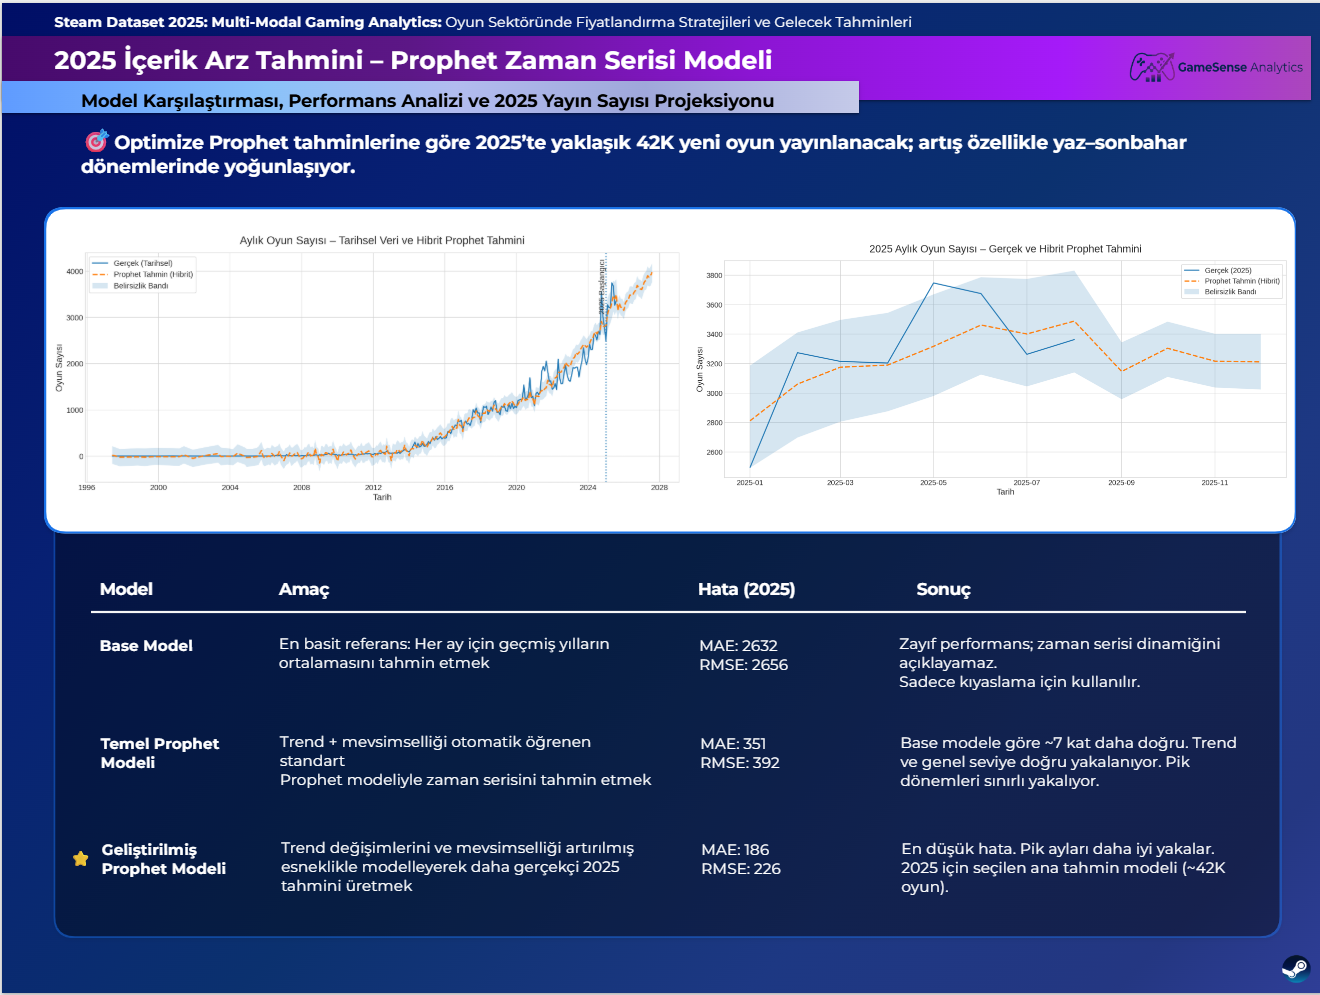